# Carga de librerías y parámetros necesarios

In [1]:
%matplotlib inline

import sys
sys.path.append("../")

from src import Estrategia, agrega_estrategias
import sqlite3
import pandas as pd

#Cargar base de días hábiles
dbpath = r'processed_data/db_habiles.db'
conn_habiles = sqlite3.connect(dbpath)
df_dias_habiles = pd.read_sql('SELECT * FROM HABILES',
                         conn_habiles, parse_dates=['Fecha'])

# PARAMETROS PARA DEFINIR LA ESTRATEGIA
#fecha_ini = datetime.datetime.strptime('2014-01-01', '%Y-%m-%d').date()
fecha_ini = pd.to_datetime('2014-01-01').date()
fecha_end = pd.to_datetime('2020-12-08').date()

afp = 'HABITAT'
monto_inicial = 100
lag_solicitud = 0

# Creación de estrategias

El objeto "Estrategia" permite crear una secuencia de cambios de fondos, de acuerdo al tipo de estrategia (pasiva o activa). En el caso de una estrategia pasiva, sólo existe 1 elemento en la secuencia, mientras que en el caso de la estrategia activa, existirán tantos elementos como sugerencias de cambios de fondos se quieran evaluar.

In [2]:
#creamos dos estrategias pasivas (fondos A y E), y una estrategia activa (según archivo "anuncios_FF.xlsx")
estrategia_a = Estrategia(fecha_ini, fecha_end, 'A')
estrategia_e = Estrategia(fecha_ini, fecha_end, 'E')
estrategia_ff = Estrategia(fecha_ini, fecha_end, 'FF',
                           'raw_data/anuncios_ff.xlsx')
estrategia_ff_inv = Estrategia(fecha_ini, fecha_end, 'FF_INV',
                           'raw_data/anuncios_ff_inversa.xlsx')

# Carga de Valores Cuota

Para obtener los valores cuotas asociados a distintas estrategias, se creó una función "agrega_estrategias", que permite tomar distintos objetos estrategia y consolidar los valores cuota de todos ellos (asumiendo un mismo "monto_inicial" invertido en las distintas estrategias).

In [3]:

lista_estrategias = [estrategia_a, estrategia_e, estrategia_ff]

df = agrega_estrategias(lista_estrategias, df_dias_habiles,
                        afp, monto_inicial, lag_solicitud)
display(df.head(5))
display(df.tail(5))

,Fecha,V_HABITAT_A_lag_0,V_HABITAT_E_lag_0,V_HABITAT_FF_lag_0,V_HABITAT_FF_INV_lag_0
0,2014-01-01,100.000000,100.000000,100.000000,100.000000
1,2014-01-02,100.336932,100.033161,100.336932,100.033161
2,2014-01-03,100.253135,100.009698,100.253135,100.009698
3,2014-01-04,100.253135,100.009698,100.253135,100.009698
4,2014-01-05,100.253135,100.009698,100.253135,100.009698


,Fecha,V_HABITAT_A_lag_0,V_HABITAT_E_lag_0,V_HABITAT_FF_lag_0,V_HABITAT_FF_INV_lag_0
2529,2020-12-04,185.420108,166.219995,171.741362,184.370632
2530,2020-12-05,185.420108,166.219995,171.741362,184.370632
2531,2020-12-06,185.420108,166.219995,171.741362,184.370632
2532,2020-12-07,185.913592,165.786726,172.020960,184.088082
2533,2020-12-08,185.913592,165.786726,172.020960,184.088082


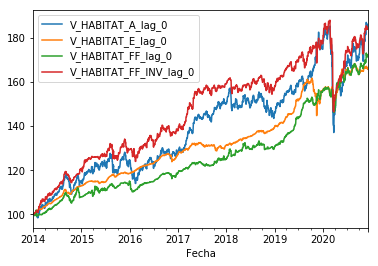

In [4]:
df.set_index('Fecha').plot()

# Comparación de Estrategias

### 2. Comparemos la estrategia FF versus fondo A y fondo E, con LAG = 0

El parámetro "lag_solicitud" permite simular cuántos días se demora una persona entre que recibe una sugerencia de cambio de fondo hasta que ingresa la solicitud. Lag=0 significa que la persona hace la solicitud de cambio de fondo el mismo día en que recibe la sugerencia de cambio de fondo.

Cabe señalar que para las estrategias pasivas, este parámetro no influye ya que no se realizan cambios de fondos.

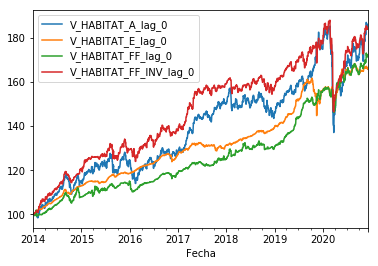

In [5]:
df = agrega_estrategias(lista_estrategias, df_dias_habiles, 
                        afp, monto_inicial, lag_solicitud=0)
df.set_index('Fecha').plot()

Usando la función "cuadro_rentabilidades", podemos obtener una versión tabular para comparar rentabilidades históricas.

- MTD: inicio de mes a la fecha
- YTD: inicio de año a la fecha
- 1y: rentabilidad últimos 12 meses
- 2y: rentabilidad últimos 24 meses
- ...

In [6]:
import seaborn as sns

from src import cuadro_rentabilidades

#la función "cuadro_rentabilidades" toma el DataFrame con valores cuota calculado previamente
df_rent = cuadro_rentabilidades(df, df_dias_habiles)

cm = sns.diverging_palette(10, 150, sep=60, n=30, as_cmap=True, l=65)

s = df_rent.style.background_gradient(cmap=cm, axis=0, \
        subset=[c for c in df_rent.columns if 'Rent' in c]).format({
        'Rent MTD': "{:.1%}", 
        'Rent YTD': "{:.1%}", 
        'Rent 1y': "{:.1%}", 
        'Rent 2y': "{:.1%}", 
        'Rent 3y': "{:.1%}", 
        'Rent 5y': "{:.1%}", 
        'Rent 8y': "{:.1%}"})
s

C:\ProgramData\Anaconda3\lib\site-packages\pandas\io\formats\style.py:1089: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(s.to_numpy()) if vmin is None else vmin
C:\ProgramData\Anaconda3\lib\site-packages\pandas\io\formats\style.py:1090: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(s.to_numpy()) if vmax is None else vmax
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


,Serie,Rent MTD,Rent YTD,Rent 1y,Rent 2y,Rent 3y,Rent 5y,Rent 8y
0,V_HABITAT_A_lag_0,0.5%,6.2%,5.6%,12.7%,7.4%,8.5%,nan%
1,V_HABITAT_E_lag_0,-0.2%,6.2%,10.0%,9.5%,8.4%,6.9%,nan%
2,V_HABITAT_FF_lag_0,0.4%,10.3%,12.5%,14.8%,11.3%,8.6%,nan%
3,V_HABITAT_FF_INV_lag_0,-0.1%,3.7%,4.8%,8.4%,5.2%,7.3%,nan%


### 3. Comparemos fondo A versus estrategia FF con 0 y 2 dias de LAG 

El parámetro "lag_solicitud" puede tomar una lista de valores, los cuales serán asociados a los elementos de la "lista_estrategias", en el mismo orden en que son dispuestos allí.

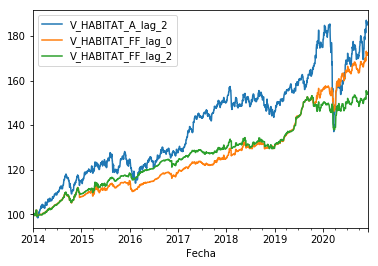

In [7]:
lista_estrategias = [estrategia_a, estrategia_ff, estrategia_ff]

df = agrega_estrategias(lista_estrategias, df_dias_habiles,
                        afp, monto_inicial, lag_solicitud=[2, 0, 2])
df.set_index('Fecha').plot()

### 4. Comparemos fondo A versus estrategia FF verus estrategia "MAX"

**HIPOTESIS:** Si alguien tiene la capacidad para "predecir" al mercado, su curva de rendimientos debería estar entre la curva pasiva y la curva de mejores rendimientos (Estrategia "MAX").

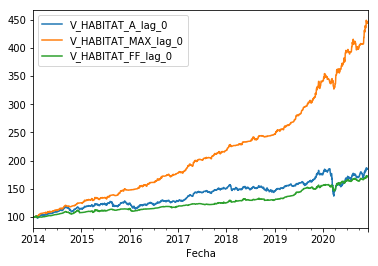

In [8]:
estrategia_max = Estrategia(fecha_ini, fecha_end, 'MAX',
                            'processed_data/optima_HABITAT.xlsx')

lista_estrategias = [estrategia_a, estrategia_max, estrategia_ff]

df = agrega_estrategias(lista_estrategias, df_dias_habiles, afp, monto_inicial, lag_solicitud=0)
df.set_index('Fecha').plot()

### Comparemos ahora con la estrategia "FF_INV"

La estrategia FF_INV sigue las recomendaciones de Felices y Forrados, pero a la inversa.

In [ ]:
lista_estrategias = [estrategia_a, estrategia_e, estrategia_ff, estrategia_ff_inv]

df = agrega_estrategias(lista_estrategias, df_dias_habiles,
                        afp, monto_inicial, lag_solicitud)
display(df.head(5))
display(df.tail(5))

df.set_index('Fecha').plot()

### 5. ¿Cómo le va a una estrategia en diferentes horizontes de tiempo?

+ Por ejemplo, supongamos que me quiero jubilar en 3 años.
+ Hay diferentes resultados dependiendo del punto de partida. [t, t+ 3 años], [t + x, t + x + 3 años]. Llamemos `offset` a ese `x`
+ Dado un horizonte de tiempo, podemos construir una distribución de resultados para cada `offset` x.

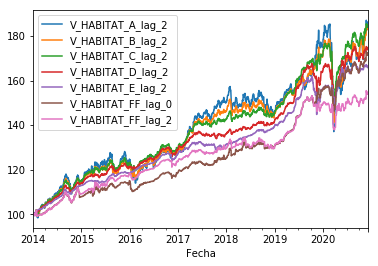

In [9]:
estrategias_afp = [Estrategia(fecha_ini, fecha_end, fondo) for fondo in ['A', 'B', 'C', 'D', 'E']]

lista_estrategias = estrategias_afp + [estrategia_ff, estrategia_ff]

df = agrega_estrategias(lista_estrategias, df_dias_habiles,
                        afp, monto_inicial, [2, 2, 2, 2, 2, 0, 2])
df.set_index('Fecha').plot()

In [10]:
horizonte_de_tiempo = pd.Timedelta(3*365, unit="d")
beg_period = df.Fecha.min()
end_period = df.Fecha.max() - horizonte_de_tiempo

all_starting_days_of_experiment = pd.date_range(beg_period, end_period, freq='d')

In [11]:
relevant_columns = [col for col in df.columns if col != 'Fecha']

rows = []
for start_date in all_starting_days_of_experiment:
    start_data = df.loc[df.Fecha == start_date, relevant_columns]
    end_data = df.loc[df.Fecha == start_date + horizonte_de_tiempo, relevant_columns]
    rows.append(pd.DataFrame(100* (end_data.values / start_data.values - 1), columns=relevant_columns,
                      index=[start_date]))

In [12]:
results = pd.concat(rows)

display(results.head(3))
display(results.tail(3))

,V_HABITAT_A_lag_2,V_HABITAT_B_lag_2,V_HABITAT_C_lag_2,V_HABITAT_D_lag_2,V_HABITAT_E_lag_2,V_HABITAT_FF_lag_0,V_HABITAT_FF_lag_2
2014-01-01,27.669397,28.042024,29.785580,29.197199,27.169933,18.744169,23.758289
2014-01-02,27.240683,27.749932,29.577455,29.087130,27.127777,18.345425,23.342708
2014-01-03,27.347037,27.771380,29.541241,29.105020,27.157602,18.444344,23.445804


,V_HABITAT_A_lag_2,V_HABITAT_B_lag_2,V_HABITAT_C_lag_2,V_HABITAT_D_lag_2,V_HABITAT_E_lag_2,V_HABITAT_FF_lag_0,V_HABITAT_FF_lag_2
2017-12-07,23.413640,25.954768,29.915652,28.788754,27.853565,37.740521,19.376936
2017-12-08,23.742098,26.198797,29.836418,28.472737,27.520302,37.964765,19.570737
2017-12-09,23.742098,26.198797,29.836418,28.472737,27.520302,37.964765,19.570737


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


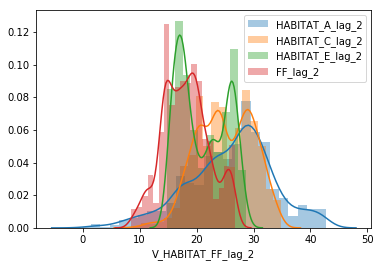

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)

sns.distplot(results[f"V_{afp}_A_lag_2"], ax=ax, label=f"{afp}_A_lag_2")
sns.distplot(results[f"V_{afp}_C_lag_2"], ax=ax, label=f"{afp}_C_lag_2")
sns.distplot(results[f"V_{afp}_E_lag_2"], ax=ax, label=f"{afp}_E_lag_2")
sns.distplot(results[f"V_{afp}_FF_lag_2"], ax=ax, label=f"FF_lag_2")
ax.legend()

In [14]:
df.describe()

,V_HABITAT_A_lag_2,V_HABITAT_B_lag_2,V_HABITAT_C_lag_2,V_HABITAT_D_lag_2,V_HABITAT_E_lag_2,V_HABITAT_FF_lag_0,V_HABITAT_FF_lag_2
count,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000,2534.000000
mean,139.325379,138.047333,138.653310,135.214587,131.800746,126.695052,126.981060
std,21.503079,20.943050,21.429837,19.579709,17.925781,18.720051,14.874597
min,98.342355,99.090895,100.000000,100.000000,100.000000,99.128675,99.053167
25%,121.537277,120.541260,121.133937,120.531037,117.883818,112.229833,115.953881
50%,143.618126,141.516796,140.368021,135.319067,130.835997,122.542069,127.631074
75%,154.155489,150.677339,150.955776,146.410402,142.320884,134.479521,134.776352
max,187.107922,184.531339,185.566637,175.345726,168.312211,173.194049,155.520050
